In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. Чтение данных
Читаем данные, удаляем ненужные колонки

In [2]:
data = pd.read_csv('./data-001.csv',
                   parse_dates=['date_time'])
data = data.drop(
    columns=['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])
data = data.sort_values(by='date_time')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
1390198,2021-09-01 00:02:49,30,596,5236744527665721365,0,0,7,1,0
5041415,2021-09-26 00:00:00,41,29,1834033519797437404,1,3,0,1,0
1442602,2021-09-26 00:00:00,1,188,7416450538971744701,2,2,15,1,0
7232498,2021-09-26 00:00:00,17,52,1832228443297591417,2,2,5,1,0
14938691,2021-09-26 00:00:00,47,73,4180077124914749282,1,4,13,1,0


### 2. Анализ данных
Проанализируем данные: статистики по каждой фиче, количество уникальных значений, отсутствующих значений, гистограммы распределений значений каждой из фич.

In [3]:
def analysis(data: pd.DataFrame):
    # множество статистических значений для датасета
    display(data.describe())

    # количество уникальных значений для каждой фичи
    print('Unique values count for each feature:')
    print(data.nunique(axis=0, dropna=True))
    print('-' * 60)

    # распределение значений каждой из фич
    for col in data.drop(columns=['date_time']).columns:
        data.hist(col, figsize=(15, 5), color='green')
        plt.show()

    # количество NaN значений в каждом столбце
    print('NaN values count for each feature:')
    print(data.isna().sum())
    print('-' * 60)

    # распределение количества сэмплов по дате и времени -- позволит увидеть, за какие моменты у нас в принципе есть данные, и в каком объеме
    print(f"Start day: {data['date_time'].min()}")
    print(f"End day: {data['date_time'].max()}")
    print("Date time samples count:")
    display(data.groupby('date_time').size())
    

Unique values count for each feature:
date_time           604712
zone_id               3444
banner_id             1633
oaid_hash          6510316
campaign_clicks        822
os_id                   11
country_id              17
impressions              1
clicks                   2
dtype: int64
------------------------------------------------------------
NaN values count for each feature:
date_time          0
zone_id            0
banner_id          0
oaid_hash          0
campaign_clicks    0
os_id              0
country_id         0
impressions        0
clicks             0
dtype: int64
------------------------------------------------------------
Start day: 2021-09-01 00:02:49
End day: 2021-10-02 23:59:59
Date time samples count:


,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,4.610505e+18,6.238540e-01,1.840605e+00,4.346986e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,2.663858e+18,9.249152e+00,1.530005e+00,4.317701e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,2.297977e+18,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,4.614236e+18,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,6.914243e+18,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,9.223371e+18,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00


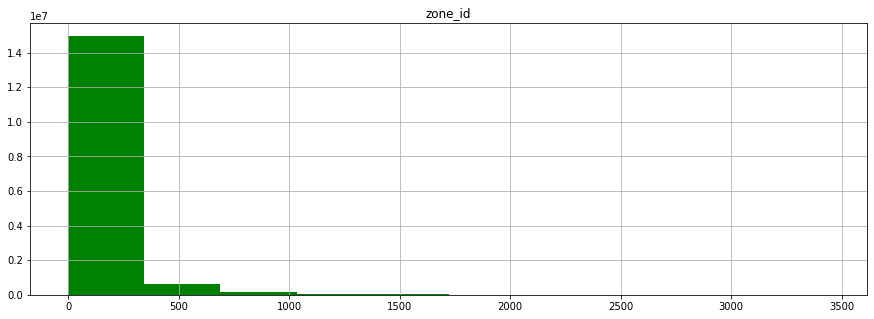

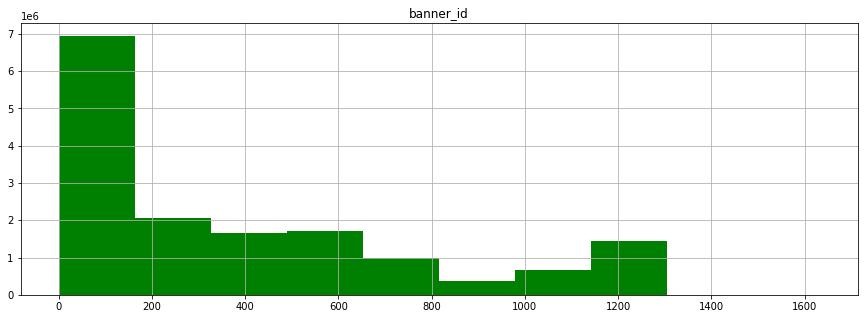

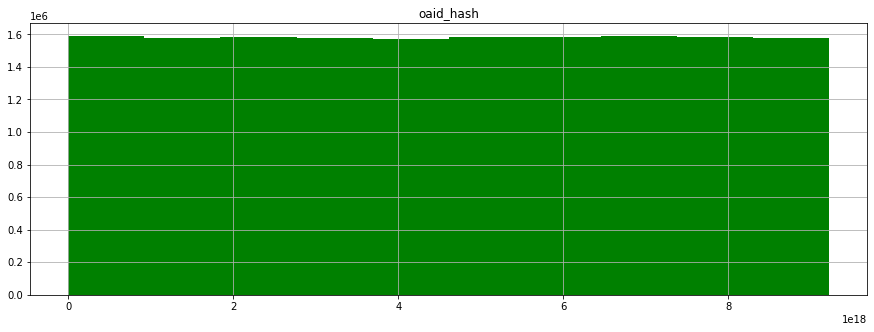

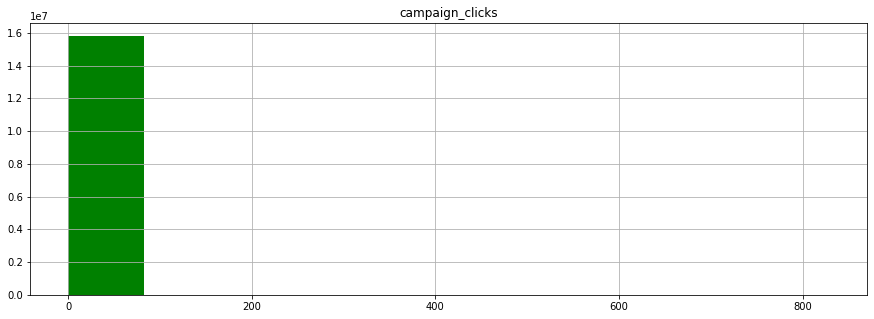

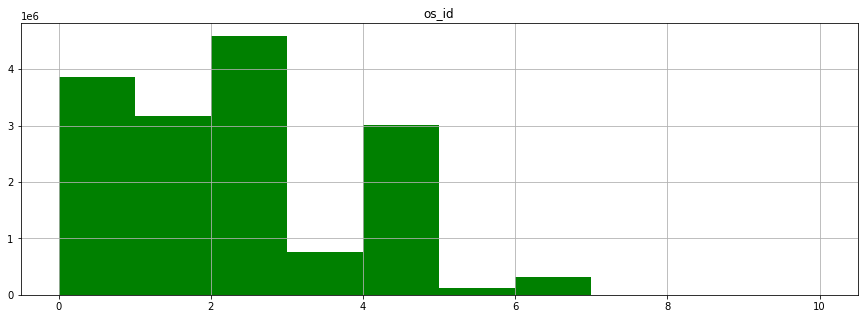

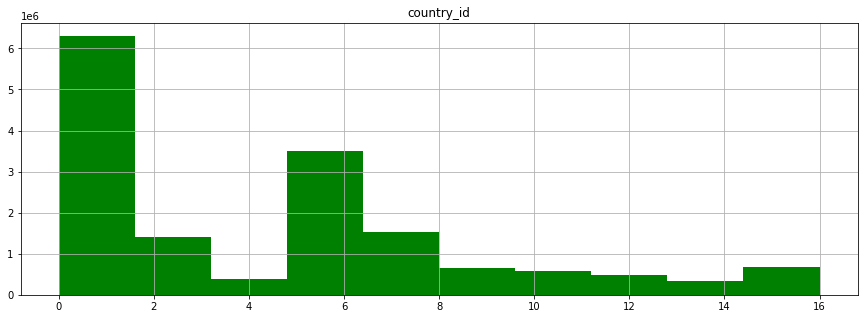

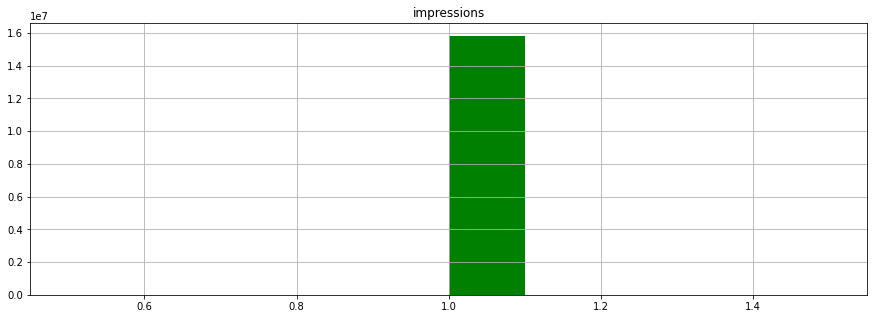

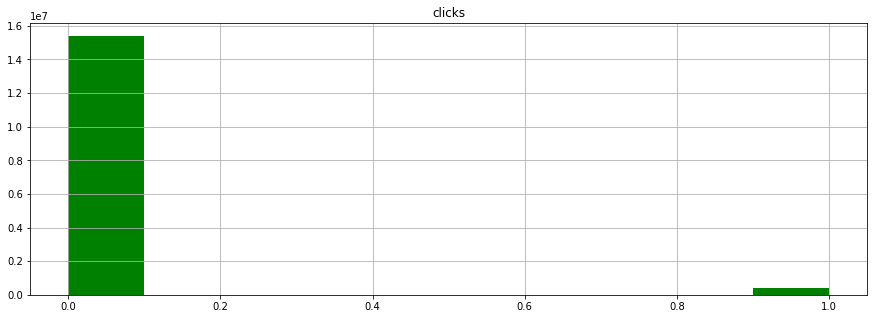

date_time
2021-09-01 00:02:49     1
2021-09-26 00:00:00    28
2021-09-26 00:00:01    28
2021-09-26 00:00:02    25
2021-09-26 00:00:03    30
                       ..
2021-10-02 23:59:55    22
2021-10-02 23:59:56    22
2021-10-02 23:59:57    19
2021-10-02 23:59:58    20
2021-10-02 23:59:59    19
Length: 604712, dtype: int64

In [4]:
analysis(data)

### 3. Фильтрация и конструирование фичей

Удалим повторяющиеся строки таблицы, если такие имеются

In [5]:
data = data.drop_duplicates()

Анализируя статистики, можем увидим, что значение поля impressions всегда одно и равно единице. Значит, все баннеры-сэмплы, данные о которых у нас имеются, в каждой конфигурации были показаны по одному разу. Так как фича является константой, она не играет роли при выборе класса объекта в нашей задаче классификации. Можем обойтись без этой колонки

In [6]:
data['impressions'].unique()

array([1])

In [7]:
data = data.drop(columns=['impressions'])
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
1390198,2021-09-01 00:02:49,30,596,5236744527665721365,0,0,7,0
5041415,2021-09-26 00:00:00,41,29,1834033519797437404,1,3,0,0
1442602,2021-09-26 00:00:00,1,188,7416450538971744701,2,2,15,0
7232498,2021-09-26 00:00:00,17,52,1832228443297591417,2,2,5,0
14938691,2021-09-26 00:00:00,47,73,4180077124914749282,1,4,13,0


Заметим, что для даты 2021-09-01 только одно наблюдение. Удалим данные за этот день из датасета как выброс.

In [8]:
data = data[data['date_time'] >= '2021-09-02']
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
5041415,2021-09-26,41,29,1834033519797437404,1,3,0,0
1442602,2021-09-26,1,188,7416450538971744701,2,2,15,0
7232498,2021-09-26,17,52,1832228443297591417,2,2,5,0
14938691,2021-09-26,47,73,4180077124914749282,1,4,13,0
11536774,2021-09-26,48,266,1459689388363839798,1,0,1,0


Заметим, что все имеющиеся данные затрагивают только 2 месяца -- сентябрь и начало октября. Информация про год избыточна, тк у всех сэмплов одинакова. Кроме того, можем убрать измерения секунд, нам хватит знания часа и минут для каждого примера. Добавим отдельные столбцы day, hour, minute. После разделения на train и test впоследствии удалим столбец date_time. Добавим информацию про день недели как новую полезную для анализа рекламных событий фичу.

In [9]:
data['day'] = data['date_time'].dt.day
data['hour'] = data['date_time'].dt.hour
data['minutes'] = data['date_time'].dt.minute
data['weekday'] = data['date_time'].dt.day_name()

data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks,day,hour,minutes,weekday
5041415,2021-09-26,41,29,1834033519797437404,1,3,0,0,26,0,0,Sunday
1442602,2021-09-26,1,188,7416450538971744701,2,2,15,0,26,0,0,Sunday
7232498,2021-09-26,17,52,1832228443297591417,2,2,5,0,26,0,0,Sunday
14938691,2021-09-26,47,73,4180077124914749282,1,4,13,0,26,0,0,Sunday
11536774,2021-09-26,48,266,1459689388363839798,1,0,1,0,26,0,0,Sunday


### 4. Train/ validate/ test splitting
Разделим данные на тренировочную, валидационную и тестовую части. Тренировать модель будем на всех данных, полученных до предпоследнего дня, валидировать -- на данных предпоследнего дня, тестировать -- на данных последнего дня, тк хотим научиться предсказывать на день вперед. 

In [10]:
from typing import Tuple

In [11]:
def split_by_the_last_day(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # разделяющий день -- последний день, начиная с 00:00
    splitting_datetime = data['date_time'].max()
    splitting_datetime = splitting_datetime.replace(hour=0, minute=0, second=0)
    print(f'Splitting datetime: {splitting_datetime}')

    train_data = data[data['date_time'] < splitting_datetime]
    test_data = data[data['date_time'] >= splitting_datetime]

    return train_data, test_data


# разделим на train_validate (train + validate части вместе) и тест
train_val_data, test_data = split_by_the_last_day(data)
# выделим validate часть
train_data, val_data = split_by_the_last_day(train_val_data)

# удалим больше ненужное поле date_time
train_data = train_data.drop(columns=['date_time'])
val_data = val_data.drop(columns=['date_time'])
test_data = test_data.drop(columns=['date_time'])

print(f'Train samples: {len(train_data)}')
print(f'Val samples: {len(val_data)}')
print(f'Test samples: {len(test_data)}')

display(train_data)
display(val_data)
display(test_data)

Splitting datetime: 2021-10-02 00:00:00
Splitting datetime: 2021-10-01 00:00:00
Train samples: 11993681
Val samples: 1637919
Test samples: 2121766


,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks,day,hour,minutes,weekday
5041415,41,29,1834033519797437404,1,3,0,0,26,0,0,Sunday
1442602,1,188,7416450538971744701,2,2,15,0,26,0,0,Sunday
7232498,17,52,1832228443297591417,2,2,5,0,26,0,0,Sunday
14938691,47,73,4180077124914749282,1,4,13,0,26,0,0,Sunday
11536774,48,266,1459689388363839798,1,0,1,0,26,0,0,Sunday
...,...,...,...,...,...,...,...,...,...,...,...
13129571,14,145,2812994566358629873,0,1,7,0,30,23,59,Thursday
11159519,168,161,8481381842118306791,0,0,1,0,30,23,59,Thursday
4748458,59,161,6502523589229511323,1,0,1,0,30,23,59,Thursday
2161751,8,1026,4446800550048584676,1,4,11,0,30,23,59,Thursday


,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks,day,hour,minutes,weekday
2747021,49,1239,5334084916871444044,0,2,0,0,1,0,0,Friday
20675,17,104,8043427820305743649,3,3,1,1,1,0,0,Friday
7465011,14,0,7558598582596132463,0,0,0,0,1,0,0,Friday
12361989,9,49,8247166999584885670,0,0,0,0,1,0,0,Friday
6811089,168,49,5703620665238317782,0,0,0,0,1,0,0,Friday
...,...,...,...,...,...,...,...,...,...,...,...
3594598,254,584,284430210636077854,0,2,10,0,1,23,59,Friday
8604214,34,47,1801023712706150066,1,2,5,0,1,23,59,Friday
1633515,3,1239,2731395125248566348,0,2,0,0,1,23,59,Friday
6571049,139,49,7391999856880902949,0,0,0,0,1,23,59,Friday


,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks,day,hour,minutes,weekday
14196412,14,1239,6628179337000354250,0,1,0,0,2,0,0,Saturday
8706638,525,174,2436793977145729294,0,3,0,0,2,0,0,Saturday
13000378,14,175,6622864732614000542,0,2,9,0,2,0,0,Saturday
9767447,0,76,3615498569651227068,0,1,3,0,2,0,0,Saturday
9054327,24,428,684235863208116380,0,1,10,0,2,0,0,Saturday
...,...,...,...,...,...,...,...,...,...,...,...
10139863,24,180,1030486855470422958,0,2,6,0,2,23,59,Saturday
5597133,73,92,5392241310084555538,0,1,0,0,2,23,59,Saturday
8660907,17,1235,5569517219693927594,0,4,0,0,2,23,59,Saturday
2991997,1,2,4888551521096100763,0,0,0,0,2,23,59,Saturday


Разделим данные на признаки X и таргет y

In [12]:
def split_to_X_y(data: pd.DataFrame):
    X = data.drop(columns=['clicks'])
    y = data['clicks']
    return X, y


X_train, y_train = split_to_X_y(train_data)
X_val, y_val = split_to_X_y(train_data)
X_test, y_test = split_to_X_y(test_data)

### 5. Обработка данных для формата libffm

Для использования *ffm* из библиотеки *xlearn* необходимо привести наши данные из *pandas.DataFrame* к специальному формату *libffm*

In [13]:
!pip install xlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for xlearn: filename=xlearn-0.40a1-py3-none-any.whl size=226632 sha256=7842f0de7a60b1943e2997be0ee6f3f766899ef1e5d7a4b4c09f4633ad5cee1a
  Stored in directory: /home/datalore/.cache/pip/wheels/0c/0a/da/aaa813e25436bce2a282cf1b3c9162c60a6e966a714e4a0b36
Successfully built xlearn

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


Разделим категориальные и числовые фичи

In [14]:
numerical_columns = ['campaign_clicks', 'day', 'hour', 'minutes']
print('Numerical columns:')
print(numerical_columns)

# все остальные столбцы, кроме numerical columns, clicks и данных о дате
categorial_columns = ['zone_id', 'banner_id', 'os_id', 'oaid_hash', 'country_id', 'weekday']
print('Categorial columns:')
print(categorial_columns)

Numerical columns:
['campaign_clicks', 'day', 'hour', 'minutes']
Categorial columns:
['zone_id', 'banner_id', 'os_id', 'oaid_hash', 'country_id', 'weekday']


In [15]:
from tqdm import tqdm

In [16]:
target_column = 'clicks'

field_dict = {}
code_num = 0


def df_to_libffm(data: pd.DataFrame, file_path: str):
    global code_num

    with open(file_path, 'w') as file:
        for _, sample in tqdm(data.iterrows(), total=len(data)):
            sample_str = f'{sample[target_column]}'

            for i, categorial_col in enumerate(categorial_columns):
                # если колонка еще не в словаре, добавим ее
                if categorial_col not in field_dict:
                    field_dict[categorial_col] = {}

                sample_col_value = sample[categorial_col]
                # заполняем словарь
                if sample_col_value not in field_dict[categorial_col]:
                    code_num += 1
                    field_dict[categorial_col][sample_col_value] = code_num

                # добавляем данные в строку 
                sample_str += f' {i}:{sample_col_value}:1'
            # записываем полученную строку в файл
            file.write(sample_str + '\n')    

Применим преобразование к train, val и test выборкам

In [17]:
df_to_libffm(train_data, './train_ffm.txt')
df_to_libffm(val_data, './val_ffm.txt')
df_to_libffm(test_data, './test_ffm.txt')

100%|██████████| 2121766/2121766 [02:08<00:00, 16466.00it/s]


### 6. Построение и обучение модели
Подключаем xlearn

In [18]:
import os

os.environ['USER'] = 'xlearn'

In [19]:
import xlearn as xl

Создаем ffm модель, указывая ей путь до train данных и параметры обучения

In [20]:
def create_fit_model(reg_lambda, embed_dim: int, trained_model_path: str):
    # задаем параметры обучения
    param = {
        'task': 'binary',
        'lr': 0.1,
        'lambda': reg_lambda,
        'k': embed_dim,
        'metric': 'auc'
    }

    ffm_model = xl.create_ffm()
    # задаем train и validate данные
    ffm_model.setTrain(train_path='./train_ffm.txt')

    # обучаем с заданными параметрами
    ffm_model.fit(param, trained_model_path)
    return ffm_model

Функция предсказания лейблов

In [21]:
import numpy as np

In [22]:
def predict(ffm_model, trained_ffm_model_path: str, test_data_path: str) -> np.array:
    # для конвертации score'а в диапазон (0, 1) вызовем метод setSigmoid()
    ffm_model.setSigmoid()
    ffm_model.setTest(test_path=test_data_path)

    # предсказываем 
    predict_res_path = './predictions.txt'
    ffm_model.predict(trained_ffm_model_path, predict_res_path)

    # читаем данные из файла с результатом, преобразуем строковые значения во float
    y_preds = pd.read_csv(predict_res_path, header=None)
    return y_preds

Функция, сравнивающая предсказания и правильные результаты: считаем метрики, печатем их

In [23]:
from sklearn.metrics import roc_auc_score, log_loss


def calc_print_metrics(y_true, y_preds):
    print(f'Roc-auc baseline: {roc_auc_score(y_true, y_preds)}')
    print(f'Log-loss baseline: {log_loss(y_true, y_preds)}')

Подберем оптимальные гиперпараметры с помощью кросс-валидации (по размеру эмбеддинга с подбором параметра регуляризации):

In [24]:
def cv():
    # задаем списки параметров
    regular_lambda_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
    embed_dim_list = [2, 4, 8, 16]

    for _, reg_lambda in tqdm(regular_lambda_list, total=len(regular_lambda_list)):
        for embed_dim in embed_dim_list:
            # создаем и обучаем модель и тестируем ее на валидационных данных
            trained_model_path = './trained_ffm_model.out'
            model = create_fit_model(reg_lambda, embed_dim, trained_model_path)

            # предсказываем результат на валидационной выборке
            y_preds = predict(model, trained_model_path, './val_ffm.txt')

            # оценим качество предсказаний при данных параметрах
            print(f'regular lambda: {reg_lambda}, embedding dim: {embed_dim}')
            calc_print_metrics(y_true=y_val, y_preds=y_preds)

In [25]:
cv()

  0%|          | 0/5 [00:00<?, ?it/s]


TypeError: TypeError: cannot unpack non-iterable float object

Лучшие гиперпараметры:

lambda = ;
embedding dim = 

Обучим модель с этими гиперпараметрами:

In [26]:
best_reg_lambda = ...
best_embed_dim = ...
best_trained_model_path = './best_trained_ffm_model.out'

model = create_fit_model(best_reg_lambda, best_embed_dim, best_trained_model_path)

TypeError: TypeError: must be real number, not ellipsis

### 8. Оценка качества обученной модели
Протестируем на тестовой выборке

In [27]:
model_preds = predict(model, best_trained_model_path, './test_ffm.txt')
calc_print_metrics(y_test, model_preds)

NameError: NameError: name 'model' is not defined

### 9. Сравнение с моделями из HW-1
В HW-1 были посчитаны метрики для бейзлайна, выдающего среднее значение таргета на train'е, а также для модели логистической регрессии.

**Метрики бейзлайна**:

Roc-auc: 0.5

Log-loss: 0.155077521266705

**Метрики модели логистической регрессии**:

Roc-auc: 0.7782649573783027

Log-loss: 0.13565754550045478

Roc auc нашей ffm модели выше, чем логистической регресии, а log loss ниже. Значит, у нас получилось обучить модель, побивающую логистическую регрессию и бейзлайн.